@This notebook was wirtten by TheCuong

Trước tiên, chúng ta import các thư viện cần thiết

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Sequential

c:\Users\WORK\anaconda3\envs\tf_gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\WORK\anaconda3\envs\tf_gpu\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\WORK\anaconda3\envs\tf_gpu\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [3]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS = 70
CHANNELS = 3

Bộ dữ liệu train mô hình được lấy từ Kanggel gồm 130 ảnh đã được phân loại thành hai lớp bị ung thư và không bị ung thư.

Đối tượng tf.data.Dataset chứa các batch của các dữ liệu hình ảnh đã được xử lý.

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "G:\My Drive\Colab Notebooks\Cancer Diagnosis\Data\OralCancer",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 130 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['cancer', 'non-cancer']

In [6]:
len(dataset)

3

Các thông số của một batch

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch[1])
    print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[189.17303  161.17303  124.173035]
  [191.88324  160.13715  124.71918 ]
  [194.4278   160.4278   125.427795]
  ...
  [180.65625  147.65625  116.65625 ]
  [180.5191   147.5191   116.519104]
  [180.84491  147.84491  116.84491 ]]

 [[190.97699  162.97699  125.97699 ]
  [192.16406  160.41797  125.      ]
  [194.       160.       125.      ]
  ...
  [185.5799   152.5799   121.579895]
  [183.55078  150.55078  119.55078 ]
  [180.06207  147.06207  116.06207 ]]

 [[192.94342  164.94342  127.94342 ]
  [193.22266  161.47656  126.05859 ]
  [192.72266  158.72266  123.72266 ]
  ...
  [189.27734  156.27734  125.27734 ]
  [186.17755  153.17755  122.17755 ]
  [181.22266  148.22266  117.22266 ]]

 ...

 [[197.8086   173.8086   139.8086  ]
  [199.01245  175.01245  139.01245 ]
  [188.80139  165.43811  125.527954]
  ...
  [ 55.        42.        36.      ]
  [ 55.        42.        36.      ]
  [ 55.        42.        36.      ]]

 [[194.50348  170.50348  136.50348 ]
  [198.7

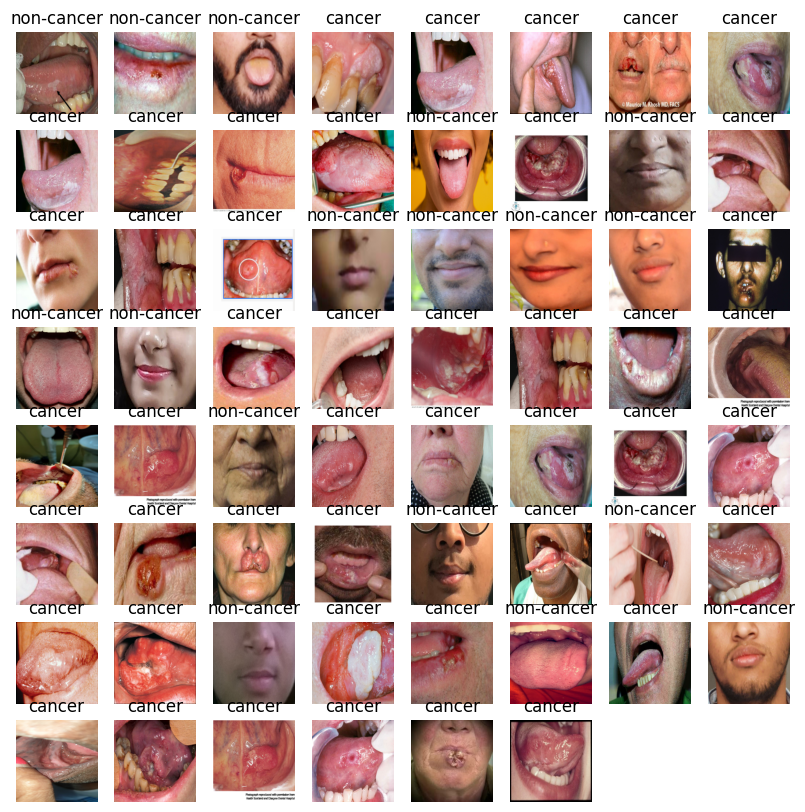

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Tiếp theo, chúng ta sẽ chia toàn bộ dữ liệu này thành 3 tập train, validation, test với tỷ lệ 8:1:1. Vì bộ dữ liệu khá ít, chúng ta sẽ lấy lặp lại 10000 lần. Dưới đây là hàm để thực hiện chức năng này.

In [8]:
def get_dataset_partitions_tf(ds, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    assert (train_size + val_size + test_size) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_size * ds_size)
    val_size = int(val_size * ds_size)
    test_size = int(test_size * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds


In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Bước đầu của việc khởi tạo mô hình, chúng ta sẽ cần chuẩn hóa ảnh về một quy chuẩn để mô hình có thể đọc được.

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

Có thể lật ảnh theo chiều ngang hoặc dọc hoặc xoay ảnh theo góc từ -20 đến 20 độ

In [11]:
data_augumention = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    # data_augumention,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.build(input_shape=input_shape)

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [15]:
with tf.device('/GPU: 0'):
    history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1,
        epochs=EPOCHS,
    )

Epoch 1/70
2/2 [==============================] - 10s 400ms/step - loss: 0.6929 - accuracy: 0.4516
Epoch 2/70
2/2 [==============================] - 0s 311ms/step - loss: 0.6325 - accuracy: 0.6774
Epoch 3/70
2/2 [==============================] - 0s 202ms/step - loss: 0.6391 - accuracy: 0.6774
Epoch 4/70
2/2 [==============================] - 0s 207ms/step - loss: 0.6215 - accuracy: 0.6774
Epoch 5/70
2/2 [==============================] - 0s 203ms/step - loss: 0.6183 - accuracy: 0.6774
Epoch 6/70
2/2 [==============================] - 0s 199ms/step - loss: 0.6095 - accuracy: 0.6774
Epoch 7/70
2/2 [==============================] - 0s 208ms/step - loss: 0.6212 - accuracy: 0.6774
Epoch 8/70
2/2 [==============================] - 0s 189ms/step - loss: 0.6129 - accuracy: 0.6774
Epoch 9/70
2/2 [==============================] - 0s 216ms/step - loss: 0.6122 - accuracy: 0.6774
Epoch 10/70
2/2 [==============================] - 0s 204ms/step - loss: 0.6008 - accuracy: 0.6774
Epoch 11/70
2/2 [=

In [16]:
model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.8892 - accuracy: 0.8333


[0.8891892433166504, 0.8333333134651184]

In [17]:
acc = history.history['accuracy']
loss = history.history['loss']

Text(0.5, 1.0, 'Loss')

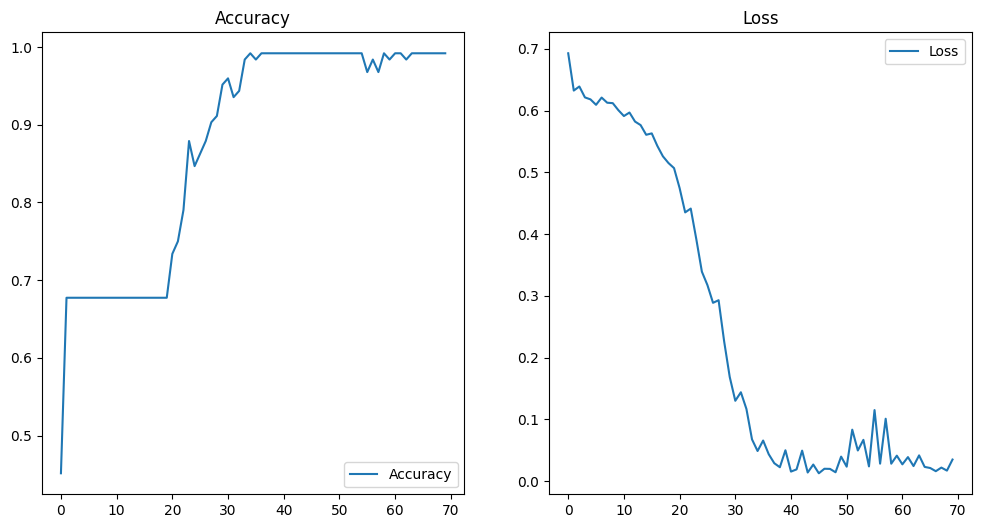

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Loss")
plt.legend(loc="upper right")
plt.title("Loss")

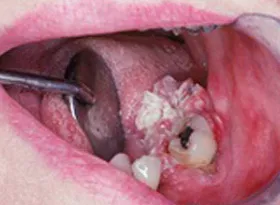

In [19]:
image_path = "G:\My Drive\Colab Notebooks\Cancer Diagnosis\Data\Testing Data set\slide4.webp"
image = tf.keras.preprocessing.image.load_img(image_path)
image_array = tf.keras.preprocessing.image.img_to_array(image)
scale_img = np.expand_dims(image_array, axis=0)
image

In [20]:
pred = model.predict(scale_img)
pred

1/1 [==============================] - 1s 685ms/step


array([[9.9917716e-01, 8.2279468e-04]], dtype=float32)

In [21]:
output = class_names[np.argmax(pred)]
output

'cancer'

Lưu mô hình

In [42]:
model.save("oral cancer detection.h5")

## Check mô hình từ file h5

In [44]:
from keras.models import load_model
model2 = load_model("oral cancer detection.h5")
model2.predict(scale_img)

1/1 [==============================] - 0s 111ms/step


array([[9.999361e-01, 6.385647e-05]], dtype=float32)